# Predicting Housing Prices with Multiple Linear Regression
_Data source_: https://www.kaggle.com/datasets/yasserh/housing-prices-dataset/data

This project uses the multiple linear regression statistical method to predict the price of a house based on certain factors like house area, bedrooms, number of stories, nearness to mainroad, etc. The dataset used has no specific mentions of a real-life city or neighbourhood that it is based on. We also do not know what currency the Price variable is in.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Examining the data
The dataset is composed of 13 total features and 545 entries. The data overall is clean with no null values in any of the columns, and has a mixture of numerical and object dtypes. I did not need to do much cleaning for this dataset.

In [3]:
df = pd.read_csv('Housing.csv',skipinitialspace=True)
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [4]:
print(df.info())  

print(df.isnull().any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB
None
price               False
area                False
bedrooms            False
bathrooms           False
stories             False
mainroad           

In [7]:
df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


## Converting Categorical Features into Numerical
To perform linear analysis, I had to convert all the categorical features that had yes/no or text answers into numerical values. I did not like the default mapping for 'funishingstatus' so after conversion I reverted that field back and remapped it to the numeric values I wanted to assign to each answer
<br> 0: 'unfurnished', 1: 'semi-furnished', 2: 'furnished'

In [8]:
categorical_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

for col in categorical_cols:
    df[col] = df[col].astype('category')
    print(f"Mapped '{col}':", dict(enumerate(df[col].cat.categories)))
    df[col] = df[col].cat.codes

Mapped 'mainroad': {0: 'no', 1: 'yes'}
Mapped 'guestroom': {0: 'no', 1: 'yes'}
Mapped 'basement': {0: 'no', 1: 'yes'}
Mapped 'hotwaterheating': {0: 'no', 1: 'yes'}
Mapped 'airconditioning': {0: 'no', 1: 'yes'}
Mapped 'prefarea': {0: 'no', 1: 'yes'}
Mapped 'furnishingstatus': {0: 'furnished', 1: 'semi-furnished', 2: 'unfurnished'}


In [9]:
reverse_mapping = {0: 'furnished', 1: 'semi-furnished', 2: 'unfurnished'}
df['furnishingstatus'] = df['furnishingstatus'].map(reverse_mapping)

custom_mapping_furnishing = {'unfurnished': 0, 'semi-furnished': 1, 'furnished': 2}
df['furnishingstatus'] = df['furnishingstatus'].map(custom_mapping_furnishing)

df['furnishingstatus'][2] #I know the 3rd entry value is 'semi-furnished' which should now be the value 1

1

## Examining Variable Relationships
Looking at the correlation matrix, we can see the correlation coefficients between multiple variables which outlines the strength of their relationship. In the case of our features, we can see that area and # of bathrooms are the variables with the strongest relationship with price.

I also wanted to see the relationship of each feature with price and used scatterplots to visualize this. This gives me an overview sense of what features may influence the housing prices and to what degree.

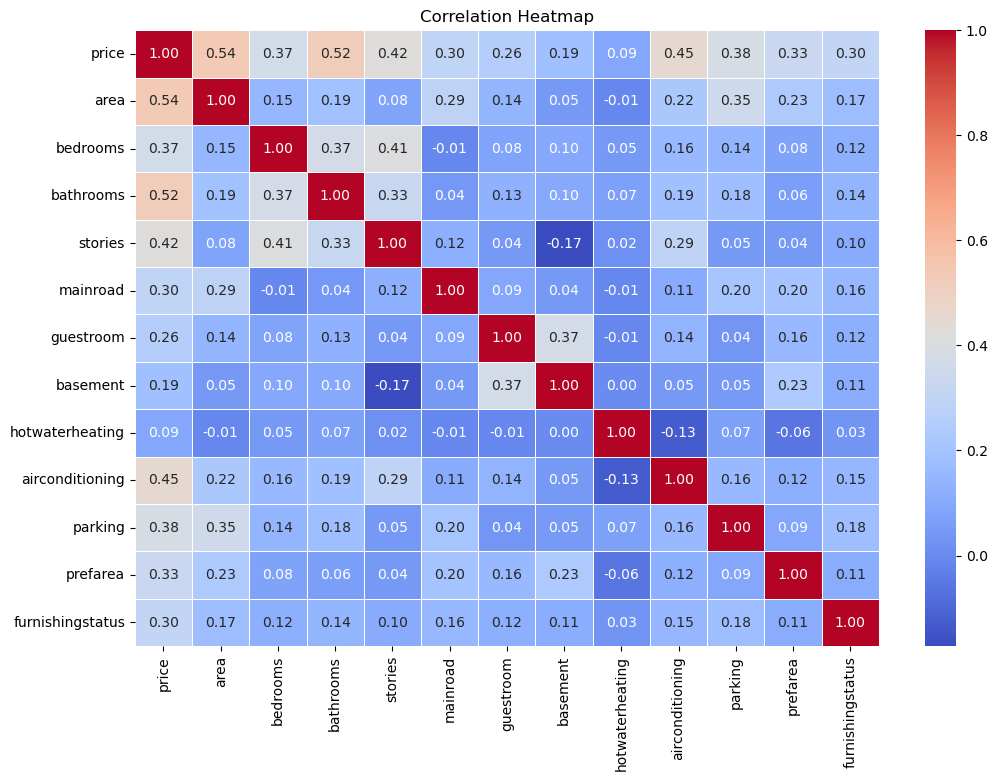

In [10]:
cor_matrix= df.corr()

plt.figure(figsize=(12, 8))  # Set the figure size
sns.heatmap(cor_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

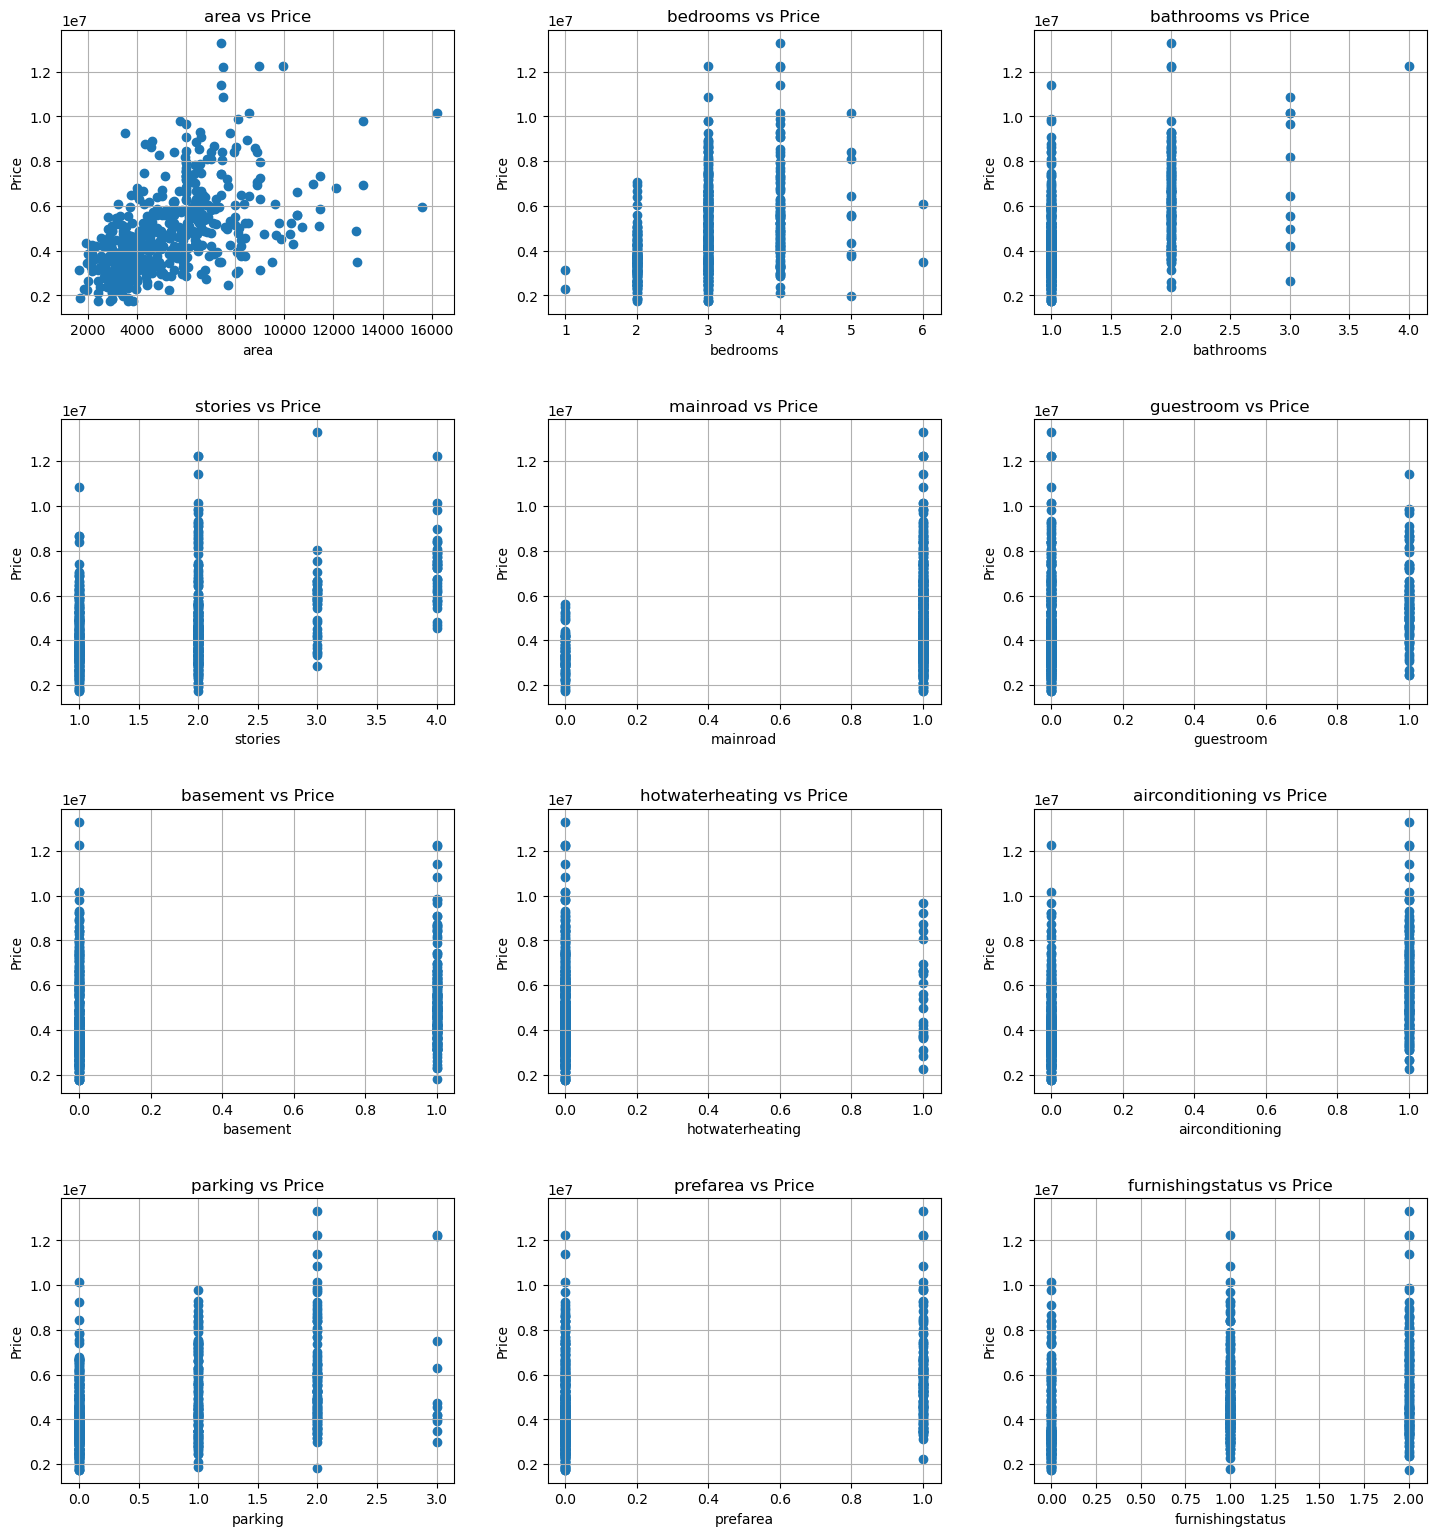

In [11]:
y_variable = df['price']
x_variables = df.columns.drop('price') 

cols = 3
rows = (len(x_variables) + cols - 1) // cols 

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten() 

for i, x_var in enumerate(x_variables):
    axes[i].scatter(df[x_var], y_variable)
    axes[i].set_xlabel(x_var)
    axes[i].set_ylabel('Price')
    axes[i].set_title(f'{x_var} vs Price')
    axes[i].grid(True)

plt.tight_layout(pad=3.0)

## Scaling, Fitting, Predicting with Linear Model

The area variable is on a vastly different range than all the other variables. Area values are in the thousands while the other variables such as # of stories and # of bathrooms are between the values of 1-5. As such, for better analysis and comparison between the features, I scaled the X training and test sets.

Prior to fitting the data and getting the model coefficients, I also wanted to check the VIF (Variance Inflation Factor) values to see if any variable/predictors will affect the standard error or the model’s stability. The VIF values all showed low multicollinearity, which indicates that there should be no issues having all these predictors included.

Using the scaled features, the Linear Regression model was used to fit the training data and predict the test data. Evaluating the model resulted in an R2 score of approximately 0.65 and RMSE of 1,331,071.42. Housing prices average in the million units here, so these 2 scores alone mean that the model is fairly decent.


In [14]:
X = df.drop(columns = 'price')
y= df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

vif_data = pd.DataFrame()
vif_data["feature"] = X_train_scaled_df.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled_df.values, i) for i in range(X_train_scaled_df.shape[1])]
print(vif_data)

             feature       VIF
0               area  1.310097
1           bedrooms  1.380557
2          bathrooms  1.296485
3            stories  1.516373
4           mainroad  1.184871
5          guestroom  1.264881
6           basement  1.382323
7    hotwaterheating  1.038207
8    airconditioning  1.262140
9            parking  1.213119
10          prefarea  1.143805
11  furnishingstatus  1.108236


In [16]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_predict= lr.predict(X_test_scaled)

In [17]:
mse = mean_squared_error(y_test, y_predict)
r2 = r2_score(y_test, y_predict)
rmse = np.sqrt(mse)

print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

R² Score: 0.6495
MSE: 1771751116594.0398
RMSE: 1331071.4168


In [18]:
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

coefficients

,Feature,Coefficient
2,bathrooms,523153.382843
0,area,519288.130105
8,airconditioning,362446.186466
3,stories,348177.113610
10,prefarea,266661.049149
9,parking,192786.985891
6,basement,188462.048566
11,furnishingstatus,158183.270169
7,hotwaterheating,150570.028279
4,mainroad,128115.927978


<b>The Coefficient values shows us the top influencing features that affect the housing price. The number of bathrooms and the area of the home are the strongest influencers, followed by whether a house has air conditioning and how many stories it is.<b>

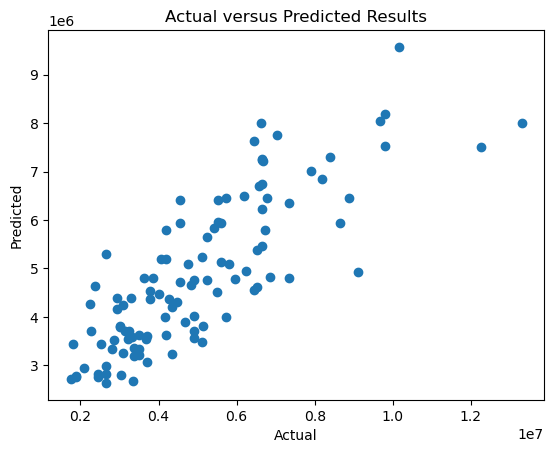

In [20]:
plt.scatter(y_test, y_predict)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Actual versus Predicted Results')
plt.show()

## Conclusion
Finally, with our model fitted and assessed, we can input an array of data for a house we want to predict the price for. 

In example 1, let's say we have a house with an area of 6000, 4 bedrooms, 2 bathrooms, is 2 stories, is near a mainroad, has a guestroom, and also has a basement, hot water heating, airconditioning, 2 parking spaces, is not in a preferred area, and is fully furnished. The predicted price of a house with all these features would be $7,947,230.19

In example 2, we have a house that only has an area of 2000, 1, bedroom, 1 bathroom, is 1 story, is not near a mainroad, does not have a guestroom, basement, or hot water heating, but has air conditioning, 1 parking space, is in a preferred area, and is not furnished. The predicted price of a house with all these features would be $3,567,110.05

These two examples they have resulted in prices that aligned within our expectation. 

In [45]:
feature_names = ['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 
                 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 
                 'prefarea', 'furnishingstatus']
#eg) 1
new_pred_x_df = pd.DataFrame([ [6000, 4, 2, 2, 1, 1, 1, 1, 1, 2, 0, 2] ], columns=feature_names)


new_pred_x_scal= scaler.transform(new_pred_x_df)

new_prediction = lr.predict(new_pred_x_scal)
print(f"Predicted House Price:", new_prediction)

Predicted House Price: [7947230.18560146]


In [46]:
#eg) 2
second_pred_x_df = pd.DataFrame([ [2000, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0] ], columns=feature_names)
new_pred_x_scal= scaler.transform(second_pred_x_df)

new_prediction = lr.predict(new_pred_x_scal)
print(f"Predicted House Price:", new_prediction)

Predicted House Price: [3567110.05329991]
